In [1]:
import numpy as np
import mujoco
import mediapy as media

In [2]:
xml = './low_cost_robot/scene.xml'
model = mujoco.MjModel.from_xml_path(xml)
data = mujoco.MjData(model)

model.vis.global_.offheight = 720
model.vis.global_.offwidth = 1080

renderer = mujoco.Renderer(model, height=720, width=1080)

In [3]:
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 0.7


In [4]:
def normalize(idx, point):
    assert 0<=point<=1
    if idx == 5:
        return 0
    ranges = [
        [np.pi/2, -np.pi/2],  # Column 1 range\n",
        [np.pi/8, -np.pi/8],  # Column 2 range\n",
        [np.pi/2, np.pi/4],  # Column 3 range\n",
        [np.pi/2, -np.pi/2],  # Column 4 range\n",
        [np.pi/2, -np.pi/2],  # Column 5 range\n",
    ]
    return ranges[idx][0] * point + ranges[idx][1] * (1 - point)

In [5]:
qinit = data.qpos.copy()
normalized_qpos = [0.5, 0.75, 1, 1, 0.5, 0]
data.qpos = np.array([normalize(idx, p) for idx, p in enumerate(normalized_qpos)])
qpos0 = data.qpos.copy()
qpos0

array([0.        , 0.19634954, 1.57079633, 1.57079633, 0.        ,
       0.        ])

In [6]:
mujoco.mj_forward(model, data)
# init_point = data.body(jname).xpos.copy()
renderer.update_scene(data, camera)
init_plot = renderer.render()
# print(init_point)

initial point

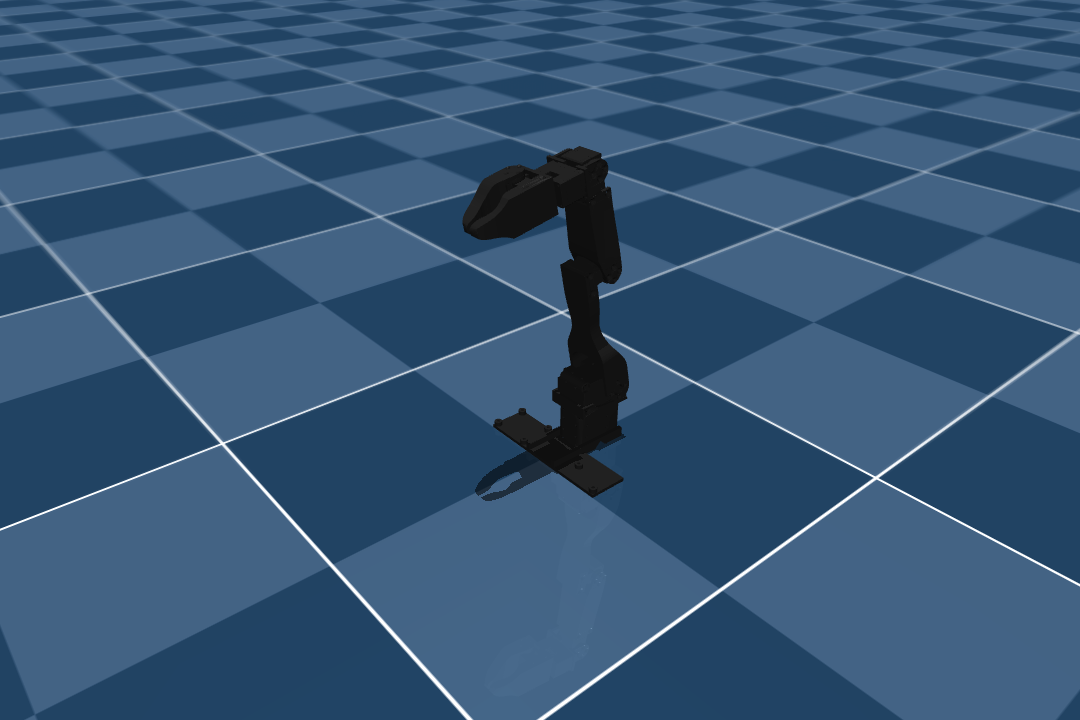

In [7]:
images = {
    "initial point": init_plot,
}
media.show_images(images=images, height=720)

In [8]:
from vis_util import open_files
np_data = open_files("aist/keypoints3d/gHO_sBM_cAll_d19_mHO2_ch07.pkl")
print(np_data.shape)

(480, 17, 3)


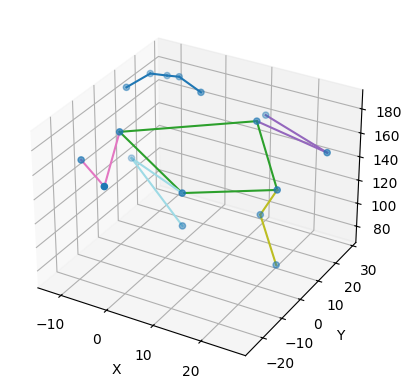

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colormaps
from vis_util import connections, connection_info, set_part_color

kpts_3d = np_data

# 특정 프레임 선택 (예: 첫 번째 프레임)
frame_idx = 200
frame_kpts = kpts_3d[frame_idx]  # shape: (17, 3)

# x, y, z 좌표 분리
x = frame_kpts[:,0]
y = frame_kpts[:,2]
z = frame_kpts[:,1]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 점 플롯
ax.scatter(x, y, z)

cmap = colormaps["tab20"].resampled(len(connection_info))
for i, (start, end) in enumerate(connections):
    xs = [x[start], x[end]]
    ys = [y[start], y[end]]
    zs = [z[start], z[end]]
    ax.plot(xs, ys, zs, c=cmap.colors[set_part_color((start, end))[0]])

# 축 라벨
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [35]:
def unit_vec(vec:np.ndarray):
    assert vec.ndim == 1 and vec.shape[0] == 3, f"Invalid vector input: {vec}"
    vec /= np.linalg.norm(vec)
    return vec


In [ ]:
from vis_util import Joint
def torso_norm_vec(np_data):
    assert np_data.ndim == 2, f"dimension of input np array is mismatched. {np_data.ndim} != 2"
    l_sholder, r_sholder, l_hip, r_hip = np_data[Joint.L_SHOLDER.value], np_data[Joint.R_SHOLDER.value], np_data[Joint.L_HIP.value], np_data[Joint.R_HIP.value]
    lt_rb, rt_lb = unit_vec(r_hip - l_sholder), unit_vec(l_hip - r_sholder)
    return np.cross(lt_rb, rt_lb)
torso_n = torso_norm_vec(np_data=np_data[1])

array([-0.25063321, -0.04073018,  0.82437565])

In [ ]:
def neck_hinge_norm_vec(np_data):
    assert np_data.ndim == 2, f"dimension of input np array is mismatched. {np_data.ndim} != 2"
    np_data[Joint.NOSE.value]


In [43]:
def leg_hinge_norm_vec(np_data):
    def calc_one_leg(hip, knee, ankle):
        up, down = unit_vec(hip - knee), unit_vec(knee - ankle)
        n = np.cross(up, down)
        up_norm_vec = np.cross(up, n)
        down_norm_vec = np.cross(down, n)
        return up_norm_vec, down_norm_vec
    assert np_data.ndim == 2, f"dimension of input np array is mismatched. {np_data.ndim} != 2"
    l_hip, l_knee, l_ankle = np_data[Joint.L_HIP.value], np_data[Joint.L_KNEE.value], np_data[Joint.L_ANKLE.value]
    r_hip, r_knee, r_ankle = np_data[Joint.R_HIP.value], np_data[Joint.R_KNEE.value], np_data[Joint.R_ANKLE.value]
    l_up_n, l_down_n = calc_one_leg(l_hip, l_knee, l_ankle)
    r_up_n, r_down_n = calc_one_leg(r_hip, r_knee, r_ankle)
    return l_up_n, l_down_n, r_up_n, r_down_n
lleg_up_n, lleg_down_n, rleg_up_n, rleg_down_n = leg_hinge_norm_vec(np_data=np_data[1])

In [ ]:
def angle_interpolate(np_datas):
    ds = np.array([unit_vec(d) for d in np_datas])
    return np.average(ds, axis=0)

leg_n = angle_interpolate([lleg_up_n, lleg_down_n, rleg_up_n, rleg_down_n])
barrel_norm_vec = angle_interpolate([leg_n, torso_n, ])

array([ 0.11468421,  0.05309562, -0.0856285 ])